<a href="https://colab.research.google.com/github/Ale613/Big-Data-Experiments/blob/main/BD_Esperimento_Inglese.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [8]:
!wget https://downloads.apache.org/spark/spark-3.5.5/spark-3.5.5-bin-hadoop3.tgz

--2025-03-04 20:10:32--  https://downloads.apache.org/spark/spark-3.5.5/spark-3.5.5-bin-hadoop3.tgz
Resolving downloads.apache.org (downloads.apache.org)... 88.99.208.237, 135.181.214.104, 2a01:4f8:10a:39da::2, ...
Connecting to downloads.apache.org (downloads.apache.org)|88.99.208.237|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 400724056 (382M) [application/x-gzip]
Saving to: ‘spark-3.5.5-bin-hadoop3.tgz.1’

spark-3.5.5-bin-had 100%[===================>] 382.16M  31.0MB/s    in 14s     

2025-03-04 20:10:46 (28.3 MB/s) - ‘spark-3.5.5-bin-hadoop3.tgz.1’ saved [400724056/400724056]



In [9]:
!tar xf spark-3.5.5-bin-hadoop3.tgz

In [10]:
!pip install -q findspark

In [11]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.5-bin-hadoop3"

In [12]:
import findspark
findspark.init()

In [13]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 13.2 MB/s eta 0:00:00


In [14]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lower, regexp_replace
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF, StringIndexer
from pyspark.ml.classification import LogisticRegression, NaiveBayes, RandomForestClassifier, DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import matplotlib.pyplot as plt
import numpy as np
from datasets import load_dataset

In [15]:
# Creazione Spark Session
spark = SparkSession.builder.appName("EmotionRecognition") \
    .master("local[*]") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

In [16]:
# Caricamento del dataset
raw_data = load_dataset("michellejieli/friends_dataset")
data = raw_data['train']

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/2.88k [00:00<?, ?B/s]

friends_cleaned.csv:   0%|          | 0.00/732k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/14503 [00:00<?, ? examples/s]

In [17]:
# Conversione in DataFrame Spark
df = spark.createDataFrame(data)

In [18]:
# Divisione in training (80%) e test (20%)
train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)

In [19]:
# Pulizia del testo
for dataset in [train_df, test_df]:
    dataset = dataset.withColumn("text", lower(col("text")))
    dataset = dataset.withColumn("text", regexp_replace(col("text"), "[^a-zA-Z ]", ""))

In [ ]:
# Label encoding
label_indexer = StringIndexer(inputCol="label", outputCol="label_index")
label_indexer_model = label_indexer.fit(train_df)  # Fit solo su train_df
train_df = label_indexer_model.transform(train_df)
test_df = label_indexer_model.transform(test_df)

In [20]:
# Tokenizzazione e rimozione stopwords
tokenizer = Tokenizer(inputCol="text", outputCol="words")
stopwords_remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")

train_df = tokenizer.transform(train_df)
test_df = tokenizer.transform(test_df)
train_df = stopwords_remover.transform(train_df)
test_df = stopwords_remover.transform(test_df)

In [21]:
# Feature extraction con TF-IDF
hashingTF = HashingTF(inputCol="filtered_words", outputCol="raw_features", numFeatures=10000)
idf = IDF(inputCol="raw_features", outputCol="features")

train_df = hashingTF.transform(train_df)
test_df = hashingTF.transform(test_df)
idf_model = idf.fit(train_df)
train_df = idf_model.transform(train_df)
test_df = idf_model.transform(test_df)

In [22]:
# Definizione dei modelli
models = {
    "Logistic Regression": LogisticRegression(featuresCol="features", labelCol="label_index"),
    "Naive Bayes": NaiveBayes(featuresCol="features", labelCol="label_index"),
    "Random Forest": RandomForestClassifier(featuresCol="features", labelCol="label_index"),
    "Decision Tree": DecisionTreeClassifier(featuresCol="features", labelCol="label_index")
}

In [23]:
# Parametri per il tuning
param_grid = {
    "Logistic Regression": ParamGridBuilder().addGrid(LogisticRegression.regParam, [0.1, 0.01, 0.001]).build(),
    "Naive Bayes": ParamGridBuilder().addGrid(NaiveBayes.smoothing, [1.0, 1.5]).build(),
    "Random Forest": ParamGridBuilder().addGrid(RandomForestClassifier.numTrees, [10, 50, 100]).build(),
    "Decision Tree": ParamGridBuilder().addGrid(DecisionTreeClassifier.maxDepth, [5, 10, 15]).build()
}

In [24]:
# Cross-validation
cross_validators = {}
for model_name, model in models.items():
    param_grid_for_model = param_grid[model_name]
    evaluator = MulticlassClassificationEvaluator(labelCol="label_index", predictionCol="prediction", metricName="accuracy")
    crossval = CrossValidator(estimator=model, estimatorParamMaps=param_grid_for_model, evaluator=evaluator, numFolds=3)
    cross_validators[model_name] = crossval

In [25]:
# Addestramento e valutazione
metrics = {"accuracy": {}, "weightedPrecision": {}, "weightedRecall": {}, "f1": {}}
for name, crossval in cross_validators.items():
    cv_model = crossval.fit(train_df)
    predictions = cv_model.transform(test_df)
    for metric in metrics.keys():
        evaluator = MulticlassClassificationEvaluator(labelCol="label_index", predictionCol="prediction", metricName=metric)
        metrics[metric][name] = evaluator.evaluate(predictions)
        print(f"{metric.capitalize()} del modello {name}: {metrics[metric][name]}")

Accuracy del modello Logistic Regression: 0.4048381358946994
Weightedprecision del modello Logistic Regression: 0.42547947606422276
Weightedrecall del modello Logistic Regression: 0.4048381358946993
F1 del modello Logistic Regression: 0.4128466291709869
Accuracy del modello Naive Bayes: 0.3888295980078264
Weightedprecision del modello Naive Bayes: 0.448852349149215
Weightedrecall del modello Naive Bayes: 0.3888295980078264
F1 del modello Naive Bayes: 0.4093900509797738
Accuracy del modello Random Forest: 0.4610458911419424
Weightedprecision del modello Random Forest: 0.21256331373886778
Weightedrecall del modello Random Forest: 0.4610458911419424
F1 del modello Random Forest: 0.2909741781933077
Accuracy del modello Decision Tree: 0.4838135894699395
Weightedprecision del modello Decision Tree: 0.36496382185900106
Weightedrecall del modello Decision Tree: 0.4838135894699395
F1 del modello Decision Tree: 0.3424399994019766


In [26]:
# Use a pipeline as a high-level helper
from transformers import pipeline
classifier = pipeline("text-classification", model="michellejieli/emotion_text_classifier")

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

config.json:   0%|          | 0.00/1.09k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/329M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/413 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

Device set to use cpu


In [27]:
# Conversione test set a Pandas per Hugging Face
test_data = test_df.select("text", "label").toPandas()

model.safetensors:   0%|          | 0.00/329M [00:00<?, ?B/s]

In [28]:
# Funzione per ottenere le predizioni
def predict_emotion(text):
    result = classifier(text)
    return result[0]['label']  # Estrai la label con punteggio più alto

In [29]:
# Applica il modello Hugging Face ai dati di test
test_data["hf_prediction"] = test_data["text"].apply(predict_emotion)

In [30]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Calcola accuracy
hf_accuracy = accuracy_score(test_data["label"], test_data["hf_prediction"])

# Precision, Recall, F1-score
hf_precision, hf_recall, hf_f1, _ = precision_recall_fscore_support(
    test_data["label"], test_data["hf_prediction"], average="weighted")

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [31]:
print(f"Accuracy Hugging Face: {hf_accuracy:.4f}")
print(f"Precision: {hf_precision:.4f}")
print(f"Recall: {hf_recall:.4f}")
print(f"F1-score: {hf_f1:.4f}")

Accuracy Hugging Face: 0.7001
Precision: 0.5733
Recall: 0.7001
F1-score: 0.6286


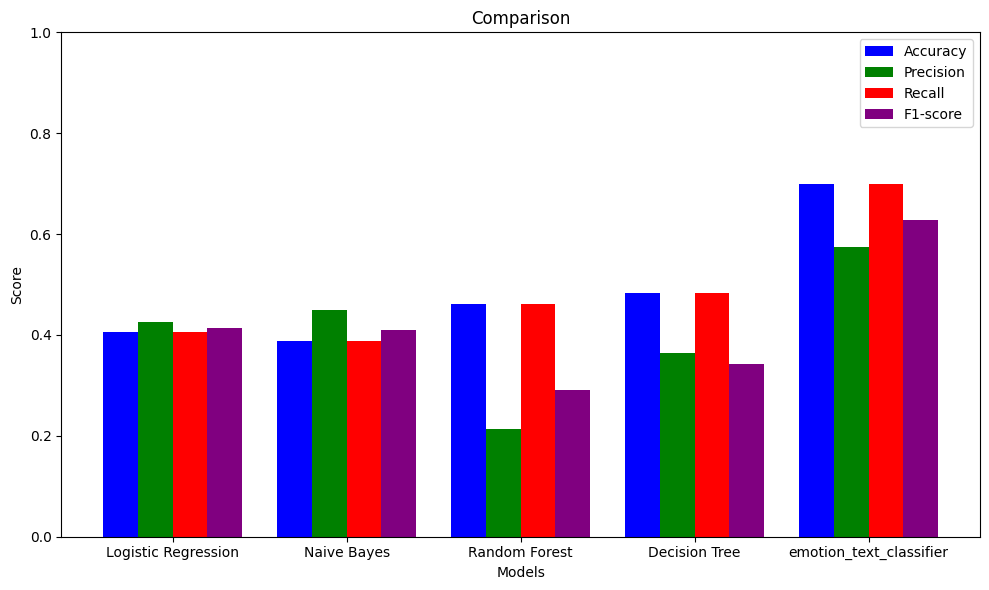

In [32]:
# Grafico
labels = list(models.keys())
labels.append("emotion_text_classifier")
metrics["accuracy"]["emotion_text_classifier"] = hf_accuracy
metrics["weightedPrecision"]["emotion_text_classifier"] = hf_precision
metrics["weightedRecall"]["emotion_text_classifier"] = hf_recall
metrics["f1"]["emotion_text_classifier"] = hf_f1
bar_width = 0.2
index = np.arange(len(labels))
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(index - 1.5 * bar_width, [metrics["accuracy"][m] for m in labels], bar_width, label="Accuracy", color='blue')
ax.bar(index - 0.5 * bar_width, [metrics["weightedPrecision"][m] for m in labels], bar_width, label="Precision", color='green')
ax.bar(index + 0.5 * bar_width, [metrics["weightedRecall"][m] for m in labels], bar_width, label="Recall", color='red')
ax.bar(index + 1.5 * bar_width, [metrics["f1"][m] for m in labels], bar_width, label="F1-score", color='purple')
ax.set_xlabel("Models")
ax.set_ylabel("Score")
ax.set_title("Comparison")
ax.set_xticks(index)
ax.set_xticklabels(labels)
ax.legend()
plt.ylim(0, 1)
plt.tight_layout()
plt.show()